In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Preprocessing
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
import category_encoders as ce

# Model selection & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [3]:
test  = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")
test.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [4]:
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")
sample_submission.head()

,id,y
0,750000,0.5
1,750001,0.5
2,750002,0.5
3,750003,0.5
4,750004,0.5


In [5]:
TARGET = "y"
ID_COL = "id"

# save test ids for submission
test_ids = test[ID_COL].copy()

In [6]:
print("train shape:", train.shape, "test shape:", test.shape)
print("target distribution:\n", train[TARGET].value_counts(normalize=True))

train shape: (750000, 18) test shape: (250000, 17)
target distribution:
 y
0    0.879349
1    0.120651
Name: proportion, dtype: float64


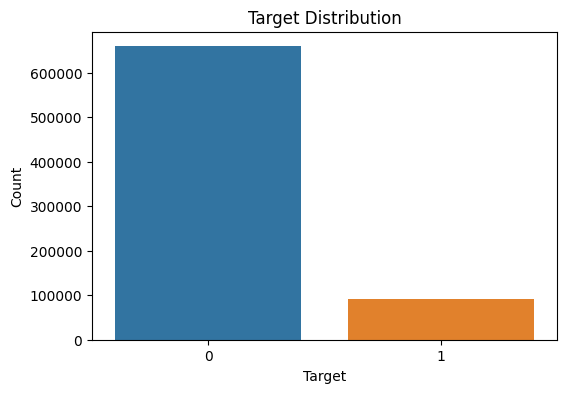

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x=train[TARGET])
plt.title("Target Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

This is a highly imbalanced dataset!


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


Numeric (int64): id, age, balance, day, duration, campaign, pdays, previous, y

Categorical (object): job, marital, education, default, housing, loan, contact, month, poutcome

In [9]:
print("Duplicates:", train.duplicated().sum())
print("\nMissing Values:", train.isna().sum())


Duplicates: 0

Missing Values: id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


Good, no duplicates or missing values

In [10]:
train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


* Negative balance is normal in banking datasets and can carry important information.

* In many banking datasets, duration can leak the target (long calls may indicate success).

In [11]:
# Drop 'duration' from training and test datasets
#train = train.drop(columns=['duration'])
#test = test.drop(columns=['duration'])

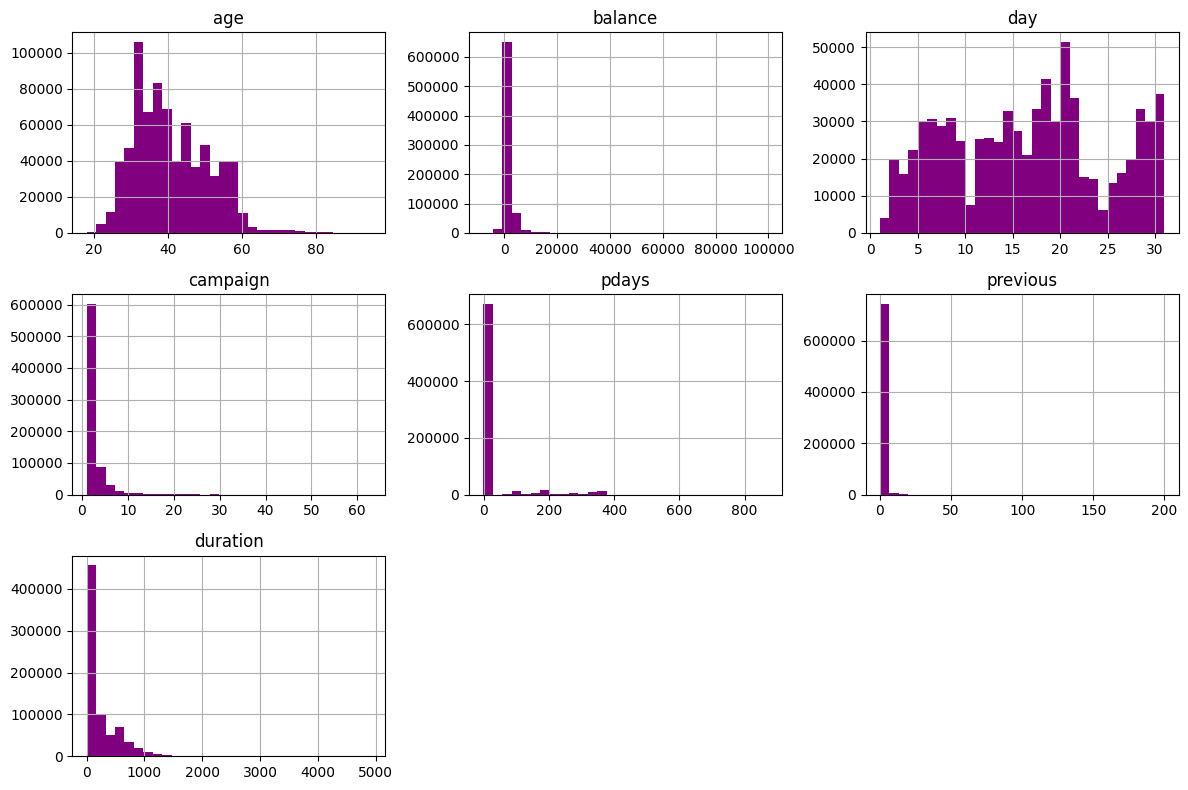

In [12]:
num_features = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous','duration']
train[num_features].hist(bins=30, figsize=(12,8),color='Purple')
plt.tight_layout()
plt.show()

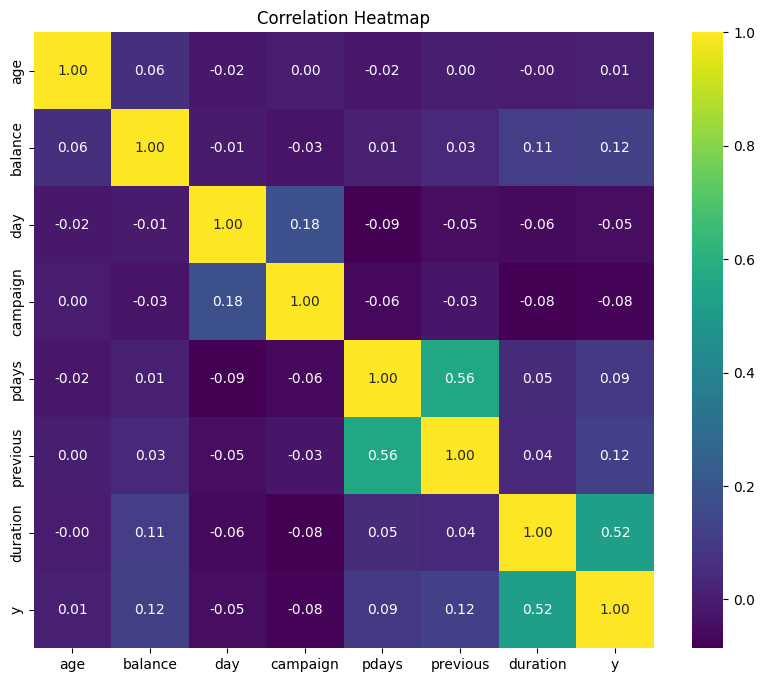

In [13]:
# Include target 'y' in numeric features
num_features = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'duration', 'y']

corr_matrix = train[num_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.title("Correlation Heatmap")
plt.show()

* No numeric feature is strongly correlated with the target. Tree-based models may still capture nonlinear patterns.
  
* Weak correlation with y suggests feature engineering or categorical features may be more important.

* I will use tree-based models (Random Forest, XGBoost) to perform better.

In [14]:
X = train.drop(columns=[ID_COL, TARGET])
X_test = test.drop(columns=[ID_COL])
y = train[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
cat_features = [col for col in X.columns if col not in num_features]

for col in cat_features:
    print(f"Value counts for {col}:")
    print(train[col].value_counts())
    print("-"*30)

Value counts for job:
job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64
------------------------------
Value counts for marital:
marital
married     480759
single      194834
divorced     74407
Name: count, dtype: int64
------------------------------
Value counts for education:
education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64
------------------------------
Value counts for default:
default
no     737151
yes     12849
Name: count, dtype: int64
------------------------------
Value counts for housing:
housing
yes    411288
no     338712
Name: count, dtype: int64
------------------------------
Value counts for loan:
loan
no     645023
yes    104977
Name: count,

In [16]:
# Encoding

# Frequency Encoding: for high-cardinality categorical features
freq_encode= ['job', 'month', 'poutcome'] # mostly unknown
for col in freq_encode:
    freq = X_train[col].value_counts()/ len(X_train)
    X_train[col] = X_train[col].map(freq)
    X_val[col] = X_val[col].map(freq)
    X_test[col] = X_test[col].map(freq)

#Label Encoding: for ordinal categorical columns
label_encode = ['default', 'housing', 'loan']
le = LabelEncoder()
for col in label_encode:
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
    X_test[col] = le.transform(X_test[col])

#One-Hot Encoding: for nominal categorical features
one_hot_cols = ['marital', 'education', 'contact']
X_train = pd.get_dummies(X_train, columns=one_hot_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=one_hot_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=one_hot_cols, drop_first=True)

# Align columns to avoid mismatch between train/test/val
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

* Frequency Encoding: high-cardinality categorical features (job, month, poutcome)

* Label Encoding: binary/few-category features (default, housing, loan)

* One-Hot Encoding: nominal features with few categories (marital, education, contact)

* Column alignment: prevents mismatch between train/val/test after one-hot encoding

In [17]:
# Scaling
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = RobustScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [18]:
print("X_train:", X_train.shape, " X_val:", X_val.shape, "X_test", X_test.shape)

X_train: (600000, 20)  X_val: (150000, 20) X_test (250000, 20)


### **Train RandomForest and XGBoost**

In [19]:
# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# Random Forest validation predictions
y_val_proba_rf = rf.predict_proba(X_val)[:,1]
y_val_pred_rf = (y_val_proba_rf >= 0.5).astype(int)

# Evaluation
val_auc_rf = roc_auc_score(y_val, y_val_proba_rf)
print("Random Forest Validation AUC:", val_auc_rf)
print("Random Forest Classification Report:\n", classification_report(y_val, y_val_pred_rf))

Random Forest Validation AUC: 0.9625167432559945
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96    131795
           1       0.77      0.63      0.69     18205

    accuracy                           0.93    150000
   macro avg       0.86      0.80      0.83    150000
weighted avg       0.93      0.93      0.93    150000



In [20]:
# Train XGBoost

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='auc',
    n_jobs= -1,
    early_stopping_rounds=50
)

# Fit with early stopping using validation set
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# XGBoost validation predictions
y_val_proba_xgb = xgb_model.predict_proba(X_val)[:,1]
y_val_pred_xgb = (y_val_proba_xgb >= 0.5).astype(int)

# Evaluation
val_auc_xgb = roc_auc_score(y_val, y_val_proba_xgb)
print("XGBoost Validation AUC:", val_auc_xgb)
print("XGBoost Classification Report:\n", classification_report(y_val, y_val_pred_xgb))

XGBoost Validation AUC: 0.96710453288488
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96    131795
           1       0.77      0.67      0.72     18205

    accuracy                           0.94    150000
   macro avg       0.86      0.82      0.84    150000
weighted avg       0.93      0.94      0.93    150000



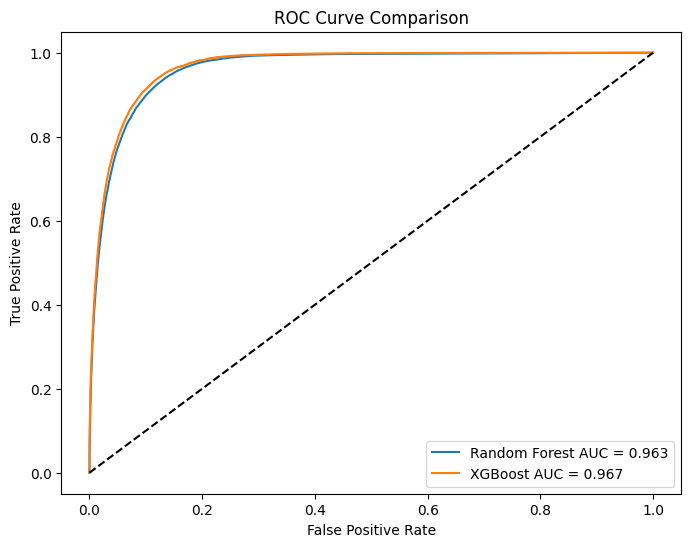

In [21]:
# Plot ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_val_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest AUC = {val_auc_rf:.3f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC = {val_auc_xgb:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

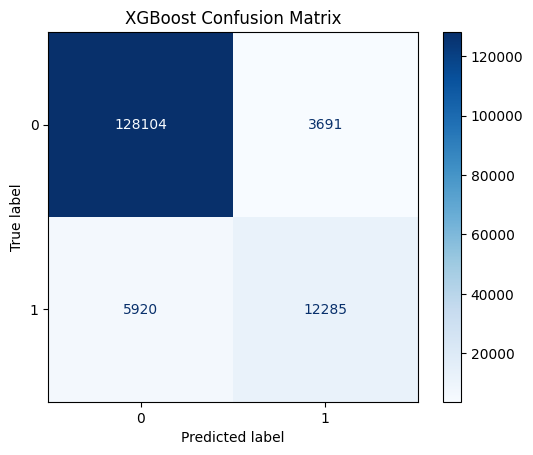

In [22]:
# Confusion Matrix

cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show()

In [23]:
# Test Set Predictions
xgb_test_probs = xgb_model.predict_proba(X_test)[:,1]
xgb_test_pred = (xgb_test_probs >= 0.5).astype(int)

In [24]:
# Create submission file
sub_xgb = pd.DataFrame({ID_COL: test_ids, TARGET: xgb_test_probs})
sub_xgb.to_csv("submission.csv", index=False)
print(sub_xgb.head())

       id         y
0  750000  0.001465
1  750001  0.119311
2  750002  0.000148
3  750003  0.000033
4  750004  0.021429
